# Synchronized Row of Metronomes
This notebook is inspired by a recent video that I discovered on Reddit showing a grouping of metronomes that spontaneously synchronized despite being started from different states.
Importantly, these are all sitting on top of a single plank, which is free to translate on top of a pair of soda cans.
The setup is similar to a Hyugens pendulum, where two clocks, when set on a common platform, will tend to synchronize.
There are some key differences, however:
- Huygens showed this behavior with two clocks, the video showed five metronomes.
- Huygens observed the two clocks oscillating with opposite phase, the video showed all five metronomes with the same phase.

We will investigate the cause of this phenomena using a the Python `sympy.physics.mechanics` module for symbolic derivation of equations of motion, along with `numpy`, `scipy`, `matplotlib`, and `IPython`.

## Setup
To setup the model, we import various engineering modules outside of Python builtins, and define some of the default conditions for evaluation.

### Imports
The fundamental dynamics of the multi-pendulum system are derived using `sympy`, with `IPython` to display nicely formatted equations. 
Efficient numerical computations are facilitated by `numpy` arrays, which are the default for `sympy.lambdify` functions.
Numerical integration of the ordinary differential equation is carried out with `scipy`.
Plotting of the simulation result is done with `matplotlib`.

In [1]:
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Latex
mechanics_printing()
from random import random
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### User Specifications
We will create a representation of multiple metronomes using a quantity `nBobs` of simple pendulums with a point mass and single angular degree-of-freedom (DoF).
For experimentation, we will randomize the initial states of the first `mRandom` bobs, while the rest will take a `defaultAngle` initial coordinate, and zero initial rate.

In [2]:
nBobs = 5
mRandom = 5
defaultAngle = 1.0

## Constants
Subscript $b$ corresponds to the properties of the flat bar that joins all the metronomes.
Without subscript is the properties of the pendulum itself. 
Mass is given by $m$, stiffness by $k$, and damping by $c$.
The distance from a pivot point to each pendulum bob is $r$.

In [3]:
mbar, m = symbols("m_b, m")
kbar, k = symbols("k_b, k")
cbar, c = symbols("c_b, c")
r = symbols("r")
constants = {
    mbar: 10.0,
    m: 0.5,
    kbar: 0.1,
    k: 5.0,
    cbar: 0.1,
    c: 0.0,
    r: 1
}

## Generalized Coordinates and Speeds


In [4]:
x, v = dynamicsymbols("x, v")
thetas = [dynamicsymbols(f"\\theta_{i}") for i in range(nBobs)]
omegas = [dynamicsymbols(f"\\omega_{i}") for i in range(nBobs)]
q = [x] + thetas
u = [v] + omegas
display(q)
display(u)

### Kinematic Equations

In [5]:
kd = [diff(q[i]) - u[i] for i in range(nBobs+1)]

### Initial Values

In [6]:
initial = {x: 0.0, v: 0.0}
for i in range(nBobs):
    initial[q[i+1]] = 2.0 * random() - 1.0 if i < mRandom else 1.0
    initial[u[i+1]] = 2.0 * random() - 1.0 if i < mRandom else 0.0
     
for state in q+u:
    display(Latex(f"${state.name}(0) = {initial[state]}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Kinematics

### Frames

In [7]:
inertial = ReferenceFrame("N")
frames = [inertial.orientnew(f"E_{i}", "Axis", [thetas[i], inertial.z]) for i in range(nBobs)]
for i in range(nBobs):
    frames[i].set_ang_vel(inertial, omegas[i]*inertial.z)

### Points

In [8]:
origin = Point("O")
origin.set_vel(inertial, Vector(0))

In [9]:
barCg = origin.locatenew("b", x*inertial.x)
barCg.set_vel(inertial, v*inertial.x)

In [10]:
pivots = [barCg.locatenew(f"p_{i}", i*inertial.x) for i in range(nBobs)]
for i in range(nBobs):
    pivots[i].set_vel(inertial, barCg.vel(inertial))

In [11]:
cgs = [pivots[i].locatenew(f"g_{i}", r*frames[i].y) for i in range(nBobs)]
for i in range(nBobs):
    cgs[i].v2pt_theory(pivots[i], inertial, frames[i])

display(cgs[0].vel(inertial))

In [12]:
display(cgs[0].acc(inertial))

## Kinetics

### Bodies

In [13]:
bar = Particle("b", barCg, mbar)

In [14]:
bobs = [Particle(f"g_{i}", cgs[i], m) for i in range(nBobs)]

In [15]:
bodies = [bar] + bobs

### Loads

In [16]:
loads = [(barCg, -(kbar*x + cbar*v)*inertial.x)] + [(frames[i], -(k*thetas[i] + c*omegas[i])*inertial.z) for i in range(nBobs)]

## Equations of Motion

In [17]:
kane = KanesMethod(inertial, q, u, kd)

In [18]:
fr, frstar = kane.kanes_equations(bodies, loads)
display(fr)

⎡    -c_b⋅v - k_b⋅x    ⎤
⎢                      ⎥
⎢-c⋅\omega₀ - k⋅\theta₀⎥
⎢                      ⎥
⎢-c⋅\omega₁ - k⋅\theta₁⎥
⎢                      ⎥
⎢-c⋅\omega₂ - k⋅\theta₂⎥
⎢                      ⎥
⎢-c⋅\omega₃ - k⋅\theta₃⎥
⎢                      ⎥
⎣-c⋅\omega₄ - k⋅\theta₄⎦

In [19]:
display(frstar)

⎡             2                           2                           2       
⎢- m⋅r⋅\omega₀ ⋅sin(\theta₀) - m⋅r⋅\omega₁ ⋅sin(\theta₁) - m⋅r⋅\omega₂ ⋅sin(\t
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [20]:
display(kane.mass_matrix)

⎡    5⋅m + m_b      -m⋅r⋅cos(\theta₀)  -m⋅r⋅cos(\theta₁)  -m⋅r⋅cos(\theta₂)  -
⎢                                                                             
⎢                            2                                                
⎢-m⋅r⋅cos(\theta₀)        m⋅r                  0                  0           
⎢                                                                             
⎢                                               2                             
⎢-m⋅r⋅cos(\theta₁)          0                m⋅r                  0           
⎢                                                                             
⎢                                                                  2          
⎢-m⋅r⋅cos(\theta₂)          0                  0                m⋅r           
⎢                                                                             
⎢                                                                             
⎢-m⋅r⋅cos(\theta₃)          0                  0    

In [21]:
display(kane.forcing)

⎡                            2                           2                    
⎢-c_b⋅v - k_b⋅x - m⋅r⋅\omega₀ ⋅sin(\theta₀) - m⋅r⋅\omega₁ ⋅sin(\theta₁) - m⋅r⋅
⎢                                                                             
⎢                                                                  -c⋅\omega₀ 
⎢                                                                             
⎢                                                                  -c⋅\omega₁ 
⎢                                                                             
⎢                                                                  -c⋅\omega₂ 
⎢                                                                             
⎢                                                                  -c⋅\omega₃ 
⎢                                                                             
⎣                                                                  -c⋅\omega₄ 

       2                           2               

## Simulation
### Mass Matrix Function

In [22]:
M = lambdify(q, kane.mass_matrix_full.subs(constants))

### Forcing Function

In [23]:
F = lambdify(q+u, kane.forcing_full.subs(constants))

### Ordinary Differential Equation

In [24]:
def f(t, x):
    invM = np.linalg.pinv(M(*x[:nBobs+1]))
    dx = invM @ F(*x)
    return dx.transpose().tolist()[0]

### Numerical Integration

In [25]:
x0 = [initial[key] for key in q+u]
tspan = 0, 100
sol = solve_ivp(f, tspan, x0, rtol=1e-6)

### Plotting

In [26]:
tPlotRange = [0, 10], [tspan[1]-10.0, tspan[1]]

#### Base Motion

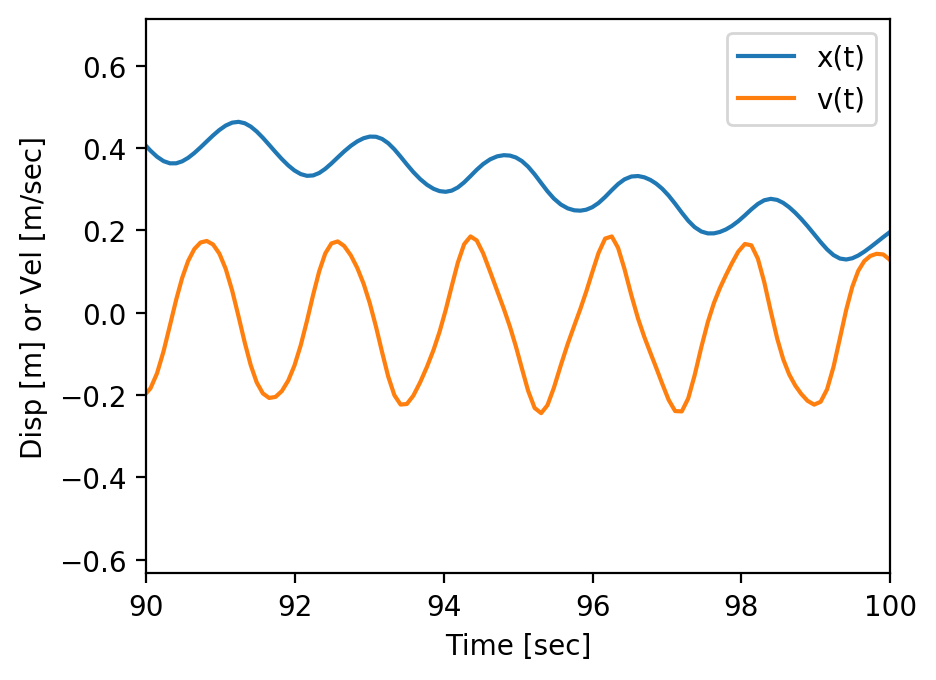

In [27]:
plt.plot(sol.t, sol.y[0].transpose());
plt.plot(sol.t, sol.y[nBobs+1].transpose());
plt.xlim(tPlotRange[1]);
plt.xlabel("Time [sec]");
plt.ylabel("Disp [m] or Vel [m/sec]");
plt.legend([q[0], u[0]]);

#### Angles
Omitting the base motion.

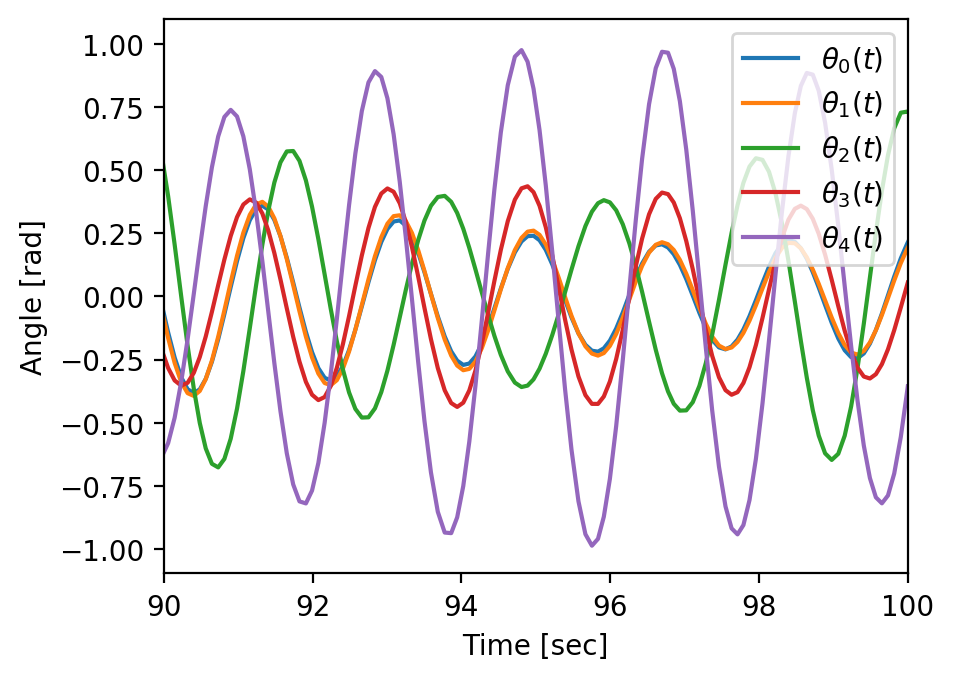

In [28]:
plt.plot(sol.t, sol.y[1:nBobs+1].transpose());
plt.xlim(tPlotRange[1]);
plt.xlabel("Time [sec]");
plt.ylabel("Angle [rad]");
plt.legend([f"${qk}$" for qk in q[1:nBobs+1]]);

#### Angular Rates

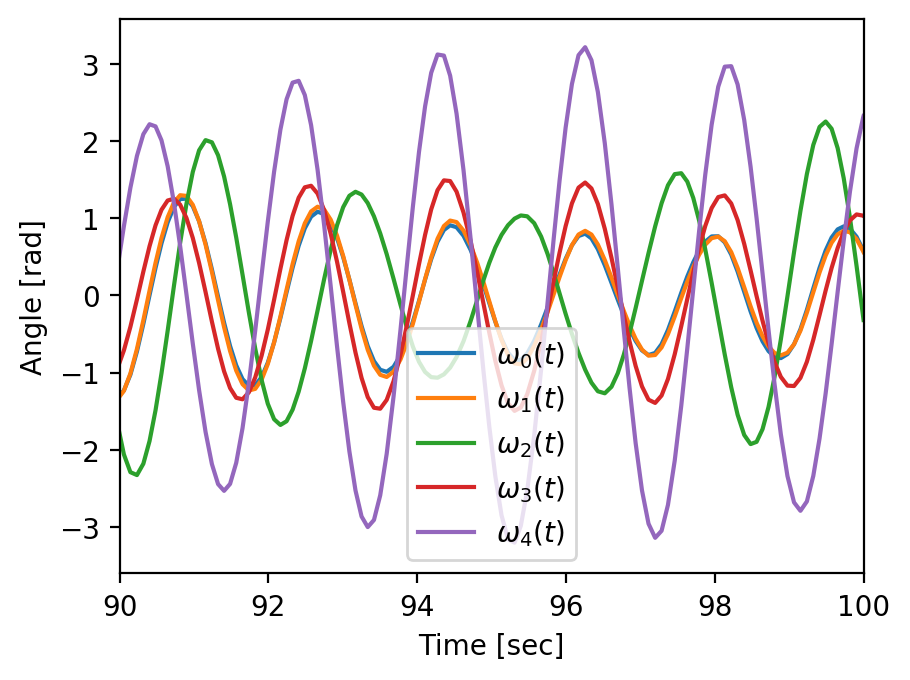

In [29]:
plt.plot(sol.t, sol.y[nBobs+2:].transpose());
plt.xlim(tPlotRange[1]);
plt.xlabel("Time [sec]");
plt.ylabel("Angle [rad]");
plt.legend([f"${uk}$" for uk in u[1:nBobs+1]]);